In [115]:
import os
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import wandb

os.environ["WANDB_SILENT"] = "true"
    

In [116]:
max_epochs = 25

In [117]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [118]:
def test_mlp(model, test_loader, print_acc=True, per_class=False, classification=False, confusion=False, misclassified=False):
    model.eval()

    correct = 0
    total = 0

    predictions = []
    gt = []
    misclassified_examples = []

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.view(inputs.size(0), -1))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            predictions.extend(predicted.tolist())
            gt.extend(labels.tolist())

            predicted = predicted.tolist()
            labels = labels.tolist()

            if misclassified:
                for i in range(len(labels)):
                    if len(misclassified_examples) == 5:
                        break
                    if labels[i] != predicted[i]:
                        misclassified_examples.append((inputs[i].cpu().numpy(), labels[i], predicted[i]))

    accuracy = 100 * correct / total
    if print_acc:
        print(f"Accuracy on the test dataset: {accuracy:.2f}%")

    if per_class:
        per_class_correct = [0] * 10
        per_class_total = [0] * 10

        for i in range(len(gt)):
            class_id = gt[i]
            if predictions[i] == class_id:
                per_class_correct[class_id] += 1
            per_class_total[class_id] += 1

        for class_id in range(10):
            class_accuracy = (per_class_correct[class_id] / per_class_total[class_id]) * 100
            print(f"Accuracy for class {class_id}: {class_accuracy:.2f}%")
    
    class_names = [str(i) for i in range(10)]
    classification_rep = classification_report(gt, predictions, target_names=class_names)
    if classification:
        print(classification_rep)
    
    if confusion:
        conf_matrix = confusion_matrix(gt, predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
    
    if misclassified:
        return accuracy, misclassified_examples
    
    return accuracy

In [119]:
def test_cnn(model, test_loader, print_acc=True, per_class=False, classification=False, confusion=False, misclassified=False):
    model.eval()

    correct = 0
    total = 0

    predictions = []
    gt = []
    misclassified_examples = []

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            predictions.extend(predicted.tolist())
            gt.extend(labels.tolist())

            predicted = predicted.tolist()
            labels = labels.tolist()

            if misclassified:
                for i in range(len(labels)):
                    if len(misclassified_examples) == 5:
                        break
                    if labels[i] != predicted[i]:
                        misclassified_examples.append((inputs[i].cpu().numpy(), labels[i], predicted[i]))

    accuracy = 100 * correct / total
    if print_acc:
        print(f"Accuracy on the test dataset: {accuracy:.2f}%")

    if per_class:
        per_class_correct = [0] * 10
        per_class_total = [0] * 10

        for i in range(len(gt)):
            class_id = gt[i]
            if predictions[i] == class_id:
                per_class_correct[class_id] += 1
            per_class_total[class_id] += 1

        for class_id in range(10):
            class_accuracy = (per_class_correct[class_id] / per_class_total[class_id]) * 100
            print(f"Accuracy for class {class_id}: {class_accuracy:.2f}%")
    
    class_names = [str(i) for i in range(10)]
    classification_rep = classification_report(gt, predictions, target_names=class_names)
    if classification:
        print(classification_rep)
    
    if confusion:
        conf_matrix = confusion_matrix(gt, predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
    
    if misclassified:
        return accuracy, misclassified_examples
    
    return accuracy

In [120]:
class PermutedMNISTDataset(Data.Dataset):
    def __init__(self, permutation_seed, split, transform=None):
        self.mnist = torchvision.datasets.MNIST("../data/", train=True, download=True, transform=transform)
        self.permutation = self.generate_permutation(permutation_seed)
        self.transform = transform

        train_size = int(0.8 * len(self.mnist))
        val_size = (len(self.mnist) - train_size) // 2
        test_size = len(self.mnist) - train_size - val_size

        train_set, val_set, test_set = Data.random_split(
            self.mnist, [train_size, val_size, test_size]
        )

        if split == 'train':
            self.mnist = train_set
        elif split == 'val':
            self.mnist = val_set
        elif split == 'test':
            self.mnist = test_set

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        image, label = self.mnist[idx]
        permuted_image = self.permute_image(image)
        permuted_image = permuted_image.reshape(1, 28, 28)
        return permuted_image, label

    def generate_permutation(self, permutation_seed):
        np.random.seed(permutation_seed)
        return torch.tensor(np.random.permutation(28 * 28))

    def permute_image(self, image):
        return image.view(-1)[self.permutation].view(image.size())

In [121]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
permutation_seed = 42

train_dataset = PermutedMNISTDataset(permutation_seed, 'train', transform)
val_dataset = PermutedMNISTDataset(permutation_seed, 'val', transform)
test_dataset = PermutedMNISTDataset(permutation_seed, 'test', transform)

train_loader = Data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = Data.DataLoader(val_dataset, batch_size=32)
test_loader = Data.DataLoader(test_dataset, batch_size=32)


In [122]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLPModel, self).__init__()
        layers = []
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size
        self.hidden_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x

In [123]:
input_size = 28 * 28
hidden_sizes = [512, 256, 128, 64]
output_size = 10

# Params using hyperparameter optimization

In [124]:
model = MLPModel(input_size, hidden_sizes, output_size)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [125]:
def train_mlp(model, train_loader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.view(inputs.size(0), -1).to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}')

In [126]:
train_mlp(model, train_loader, max_epochs)

Epoch 1/25, Loss: 0.3829633389804512
Epoch 2/25, Loss: 0.17207375577588876
Epoch 3/25, Loss: 0.13367852407693864
Epoch 4/25, Loss: 0.11065941269839338
Epoch 5/25, Loss: 0.09442397857608739
Epoch 6/25, Loss: 0.08454501682636328
Epoch 7/25, Loss: 0.07761655398011984
Epoch 8/25, Loss: 0.06889215939905262
Epoch 9/25, Loss: 0.06394300011559971
Epoch 10/25, Loss: 0.058332634906236004
Epoch 11/25, Loss: 0.0547784217777565
Epoch 12/25, Loss: 0.05061559528889484
Epoch 13/25, Loss: 0.04799172089137816
Epoch 14/25, Loss: 0.043908898076435436
Epoch 15/25, Loss: 0.03953426309598338
Epoch 16/25, Loss: 0.04052482989613418
Epoch 17/25, Loss: 0.03644005966726953
Epoch 18/25, Loss: 0.038210576135146765
Epoch 19/25, Loss: 0.03583625873198859
Epoch 20/25, Loss: 0.03335854667188748
Epoch 21/25, Loss: 0.032261298549156284
Epoch 22/25, Loss: 0.03179393933309742
Epoch 23/25, Loss: 0.031936618697483744
Epoch 24/25, Loss: 0.029860716112144775
Epoch 25/25, Loss: 0.02700502088472937


In [127]:
test_mlp(model, train_loader)
test_mlp(model, val_loader)

Accuracy on the test dataset: 99.42%
Accuracy on the test dataset: 99.33%


99.33333333333333

Accuracy on the test dataset: 99.08%
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       603
           1       1.00      1.00      1.00       709
           2       1.00      0.99      1.00       610
           3       0.99      0.99      0.99       623
           4       0.99      0.97      0.98       560
           5       0.99      0.99      0.99       553
           6       1.00      0.99      1.00       562
           7       0.99      0.99      0.99       587
           8       1.00      0.99      0.99       610
           9       0.96      0.99      0.97       583

    accuracy                           0.99      6000
   macro avg       0.99      0.99      0.99      6000
weighted avg       0.99      0.99      0.99      6000



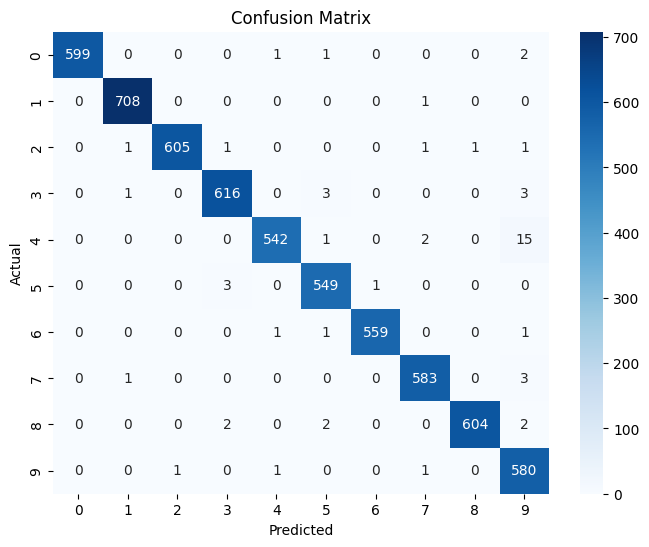

99.08333333333333

In [128]:
test_mlp(model, test_loader, classification=True, confusion=True)

In [129]:
class CNN(nn.Module):
    def __init__(self, dropout=0.5):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) # 32 * 14 * 14
        x = self.pool(torch.relu(self.conv2(x))) # 64 * 7 * 7
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        # x = self.softmax(x)
        return x

# Params using hyperparameter optimization

In [130]:
def train_cnn(model, train_loader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}')

In [131]:
cnn_model = CNN()
cnn_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

train_cnn(cnn_model, train_loader, max_epochs)

Epoch 1/25, Loss: 0.5901439145406088
Epoch 2/25, Loss: 0.27762717959284783
Epoch 3/25, Loss: 0.21714106301932284
Epoch 4/25, Loss: 0.18451889762779078
Epoch 5/25, Loss: 0.16090676183920974
Epoch 6/25, Loss: 0.14457729228648047
Epoch 7/25, Loss: 0.1319628218934716
Epoch 8/25, Loss: 0.11753513414443781
Epoch 9/25, Loss: 0.10806584908983981
Epoch 10/25, Loss: 0.1018922949709231
Epoch 11/25, Loss: 0.0986377230626919
Epoch 12/25, Loss: 0.08891831159723612
Epoch 13/25, Loss: 0.08538520544094111
Epoch 14/25, Loss: 0.07991487299790606
Epoch 15/25, Loss: 0.07583392187888967
Epoch 16/25, Loss: 0.0731818104054158
Epoch 17/25, Loss: 0.07166611540286977
Epoch 18/25, Loss: 0.06690734013576366
Epoch 19/25, Loss: 0.06521790788723107
Epoch 20/25, Loss: 0.06283194497620329
Epoch 21/25, Loss: 0.05922588578300444
Epoch 22/25, Loss: 0.05823096118837081
Epoch 23/25, Loss: 0.05937754579899653
Epoch 24/25, Loss: 0.05479896237169548
Epoch 25/25, Loss: 0.053907153015482136


In [132]:
test_cnn(cnn_model, train_loader)
test_cnn(cnn_model, val_loader)

Accuracy on the test dataset: 99.67%
Accuracy on the test dataset: 99.10%


99.1

Accuracy on the test dataset: 99.13%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       603
           1       1.00      1.00      1.00       709
           2       0.99      0.99      0.99       610
           3       0.99      0.98      0.99       623
           4       0.99      0.99      0.99       560
           5       0.99      0.99      0.99       553
           6       1.00      1.00      1.00       562
           7       0.99      0.99      0.99       587
           8       0.98      1.00      0.99       610
           9       0.99      0.98      0.98       583

    accuracy                           0.99      6000
   macro avg       0.99      0.99      0.99      6000
weighted avg       0.99      0.99      0.99      6000



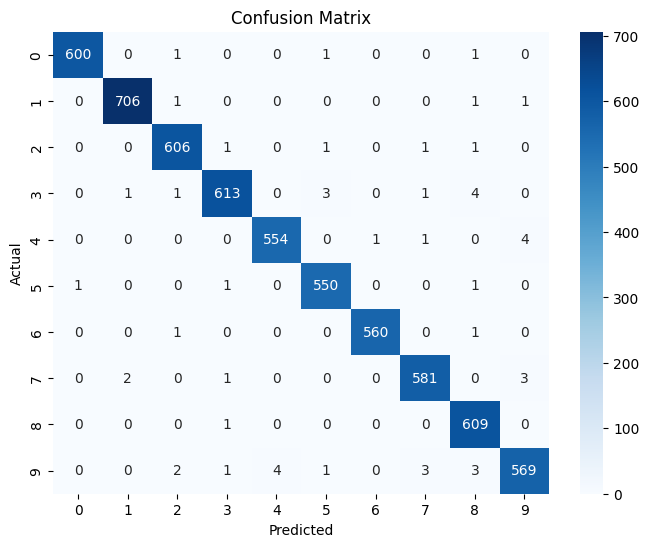

99.13333333333334

In [133]:
test_cnn(cnn_model, test_loader, classification=True, confusion=True)

We can see here that the CNN gives better results as compared to MLP over similar number of epochs. 